# Camera geometric calibration
Camera calibration is used to obtain the camera parameters:

## Offline

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os 
import glob  

The function **click_event** is called every time the user clicks on the image.
- **event**: stores the kind of interaction with the window
- **x, y**: the coordinates of the click
- **flags, params**: additional information

The **"if event == cv2.EVENT_LBUTTONDOWN"** statement checks whether the click is a left click. Then a green circle is added at the coordinates of the click.

If we add 4 points (circles) then the **interpolation** process happens.

In [2]:
def manual_corners(img):
    global points, original_img

    def redraw_points():
            global img, points, original_img
            font = cv.FONT_HERSHEY_SIMPLEX
            img = original_img.copy()  # Reset the image to the original without any drawings
            for pt in points:
                cv.circle(img, pt, 3, (0, 255, 0), -1)
                cv.putText(img, str(pt[0]) + ',' + str(pt[1]), pt, font, 1, (255, 0, 0), 2)
            cv.imshow('Image', img)

    def select_corners(event, x, y, flags, params):
            global points, img
            if event == cv.EVENT_LBUTTONDOWN and len(points) < 4:
                points.append((x, y))
                redraw_points()

            elif event == cv.EVENT_RBUTTONDOWN and len(points) > 0:
                points = points[:-1]
                redraw_points()


    # Load chessboard image
    original_img = img.copy()  # Keep an original copy of the image
    cv.imshow('Image', img)

    points = []
    cv.setMouseCallback('Image', select_corners)

    cv.waitKey(0)
    cv.destroyAllWindows()

    points = np.array(points)
    return points

In [28]:
points

array([[ 234,  100],
       [ 883,   99],
       [  93,  660],
       [1025,  661]])

In [3]:
def sort_corners(corners):
    # Sort the corners: [top-left, top-right, bottom-right, bottom-left]
    # (Assuming corners is a numpy array of shape (4, 2))
    top = sorted(corners[:2], key=lambda x: x[0])
    bottom = sorted(corners[2:], key=lambda x: x[0], reverse=True)
    return np.array(top + bottom, dtype='float32')

def interpolate_chessboard_points(outer_corners, pattern_size, square_size):
    # Sort corners
    sorted_corners = sort_corners(outer_corners)

    # Destination points - a perfect rectangle
    dest_corners = np.array([[0, 0],
                             [square_size * (pattern_size[0] - 1), 0],
                             [square_size * (pattern_size[0] - 1), square_size * (pattern_size[1] - 1)],
                             [0, square_size * (pattern_size[1] - 1)]], dtype='float32')

    # Perspective transformation matrix
    matrix = cv.getPerspectiveTransform(sorted_corners, dest_corners)

    # Interpolate points
    interpolated_points = []
    for i in range(pattern_size[1]):
        for j in range(pattern_size[0]):
            point = np.array([j * square_size, i * square_size, 1], dtype='float32')
            point = matrix.dot(point)
            point /= point[2]  # Normalize
            interpolated_points.append((int(point[0])*-1, int(point[1])*-1))

    # Draw the interpolated points on the image
    for point in interpolated_points:
        cv.circle(img, point, 5, (0, 255, 0), -1)

    # Display the image with points
    cv.imshow('Interpolated Points', img)
    cv.waitKey(0)
    cv.destroyAllWindows()

    return np.array(interpolated_points, dtype='float32')

In [17]:
def calibrate(showPics=True):
    
    # Find image file paths
    imgPathList = glob.glob(os.path.join('images','*.jpg'))
    print(imgPathList)
    
    # Dimensions of the chessboard
    chessboard_dim = (9,6)
    square_size = 30  # Assuming each square is 30x30 units
    
    # Termination criteria
    termCriteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER,30,0.001)
    
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    obj_3D = np.zeros((chessboard_dim[0]*chessboard_dim[1],3), np.float32)
    obj_3D[:,:2] = np.mgrid[0:chessboard_dim[0], 0:chessboard_dim[1]].T.reshape(-1,2)
    obj_3D *= square_size
    
    # Empty lists to store our points as we calibrate the camera
    obj_points_3D = [] # 3d points in real world space
    img_points_2D = [] # 2d points in image plane
    
    
    # Find corners 
    print()
    for curImgPath in imgPathList:
        print('Current path:')
        print(curImgPath)
        
        # Read the image
        imgBGR = cv.imread(curImgPath)  
        
        # Half the size of the image
        imgScale = 0.5
        newX,newY = imgBGR.shape[1]*imgScale, imgBGR.shape[0]*imgScale
        imgBGR = cv.resize(imgBGR,(int(newX),int(newY)))
        
        imgGray = cv.cvtColor(imgBGR, cv.COLOR_BGR2GRAY) # Turn to greyscale
        
        # Try to find corners with the cv function 'findChessboardCorners'
        cornersFound, corners = cv.findChessboardCorners(imgGray, chessboard_dim, None)

        if cornersFound == True:
            print('Found with the CV function')
            # Append them to the list of our world points
            obj_points_3D.append(obj_3D)
            cornersRefined = cv.cornerSubPix(imgGray, corners, (3,3), (-1,-1), termCriteria)
            img_points_2D.append(cornersRefined)

            if showPics: 
                cv.drawChessboardCorners(imgBGR, chessboard_dim, cornersRefined, cornersFound)
                cv.imshow('Chessboard', imgBGR)
                cv.waitKey(500)
                
        else:
            # Get the corners manually
            outer_corners = manual_corners(imgBGR)
            # outer_corners = np.array([[234, 100], [883, 100], [234, 660], [883, 660]])
            
            interpolated_points = interpolate_chessboard_points(outer_corners, chessboard_dim, square_size)
                
    
    if showPics:           
        cv.destroyAllWindows()
    5
    # Calibrate 
    repError, camMatrix, distCoeff, rvecs, tvecs = cv.calibrateCamera(obj_points_3D, img_points_2D, imgGray.shape[::-1],None,None)
    print('Camera Matrix:\n',camMatrix)
    print("Reproj Error (pixels): {:.4f}".format(repError))
    
    # Save Calibration Parameters (later video)
    curFolder = os.path.dirname(os.path.abspath('1'))
    paramPath = os.path.join(curFolder,'calibration.npz')
    np.savez(paramPath, repError=repError, camMatrix=camMatrix, distCoeff=distCoeff, rvecs=rvecs, tvecs=tvecs)
    
    
    
    
    

    
    

In [18]:
calibrate()

['images\\1.jpg', 'images\\10.jpg', 'images\\11.jpg', 'images\\12.jpg', 'images\\13.jpg', 'images\\14.jpg', 'images\\15.jpg', 'images\\16.jpg', 'images\\17.jpg', 'images\\18.jpg', 'images\\19.jpg', 'images\\2.jpg', 'images\\20.jpg', 'images\\21.jpg', 'images\\22.jpg', 'images\\23.jpg', 'images\\24.jpg', 'images\\25.jpg', 'images\\26.jpg', 'images\\27.jpg', 'images\\28.jpg', 'images\\29.jpg', 'images\\3.jpg', 'images\\4.jpg', 'images\\5.jpg', 'images\\6.jpg', 'images\\7.jpg', 'images\\8.jpg', 'images\\9.jpg']

Current path:
images\1.jpg
Found with the CV function
Current path:
images\10.jpg
Found with the CV function
Current path:
images\11.jpg
Found with the CV function
Current path:
images\12.jpg
Found with the CV function
Current path:
images\13.jpg
Found with the CV function
Current path:
images\14.jpg
Found with the CV function
Current path:
images\15.jpg
Found with the CV function
Current path:
images\16.jpg
Found with the CV function
Current path:
images\17.jpg
Found with the CV 

In [56]:
def interpolate_corners(corners, pattern_size):
    # Ensure corners are (top-left, top-right, bottom-right, bottom-left)
    # ... Sorting logic here ...

    # Calculate step sizes
    step_x = (corners[1][0] - corners[0][0]) / (pattern_size[0] - 1)
    step_y = (corners[3][1] - corners[0][1]) / (pattern_size[1] - 1)

    # Generate points
    inner_points = []
    for i in range(pattern_size[1]):
        for j in range(pattern_size[0]):
            x = corners[0][0] + j * step_x
            y = corners[0][1] + i * step_y
            inner_points.append((int(x), int(y)))

    return inner_points

In [61]:
pattern_size = (7, 7)  # For a 8x8 chessboard
interpolated_points = np.array(interpolate_corners(points, pattern_size))

In [62]:
interpolated_points.shape

(49, 2)

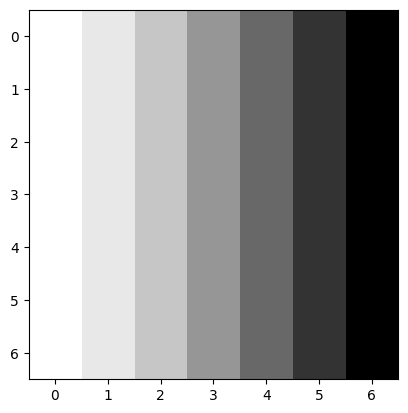

In [67]:
plt.imshow(interpolated_points[:,0].reshape(7,7), cmap='Greys')

In [29]:
# Calculate step sizes (assuming 7x7 grid of inner corners for an 8x8 chessboard)
step_size_x = (points[1][0] - points[0][0]) / 6
step_size_y = (points[3][1] - points[0][1]) / 6

# Generate inner points
inner_points = []
for row in range(7):
    for col in range(7):
        x = points[0][0] + col * step_size_x
        y = points[0][1] + row * step_size_y
        inner_points.append((int(x), int(y)))

inner_points = np.array(inner_points)


In [31]:
inner_points.shape

(49, 2)

In [32]:
# Assuming each cell of the chessboard is of a known size, e.g., 20mm
cell_size = 20  # replace with the actual size of your chessboard cell

# Prepare the 3D points (0,0,0), (20,0,0), (40,0,0), ..., etc.
objp = np.zeros((7*7, 3), np.float32)
objp[:,:2] = np.mgrid[0:7, 0:7].T.reshape(-1, 2) * cell_size

# 'objp' is now the array of your 3D points in the real world


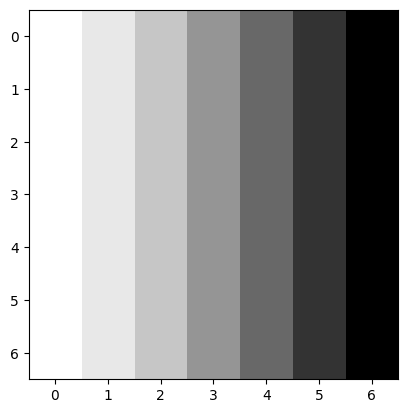

In [53]:
plt.imshow(objp[:,:1].reshape(7,7), cmap='Greys')

### Example with automatic edge detection

In [24]:
import cv2
import numpy as np

img = cv2.imread('chessboard.png')

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Apply bilateral filter
bi = cv2.bilateralFilter(gray, 5, 75, 75)
# Display the result

dst = cv2.cornerHarris(bi, 2, 3, 0.04)

#--- create a black image to see where those corners occur ---
mask = np.zeros_like(gray)

#--- applying a threshold and turning those pixels above the threshold to white ---           
mask[dst>0.01*dst.max()] = 255
cv2.imshow('Mask', mask)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [16]:
img[dst > 0.01 * dst.max()] = [0, 0, 255]   #--- [0, 0, 255] --> Red ---
cv2.imshow('Dst', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

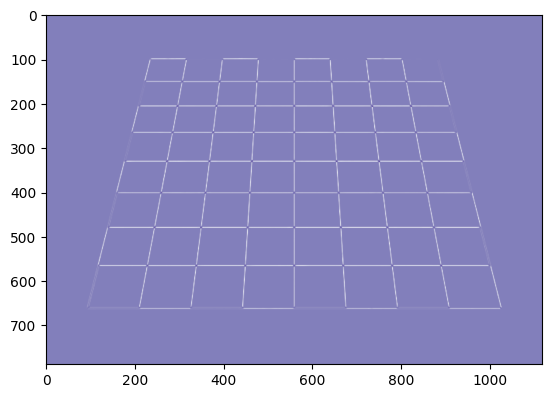

In [12]:
plt.imshow(dst, cmap='Purples')

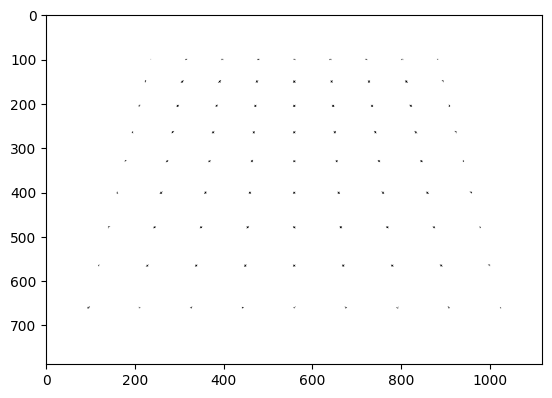

In [14]:
plt.imshow(mask, cmap='Greys')